In [1]:
# MLM 방식을 이용한 Further pre-traning 방식 구현 예제
# 참고 소스 : https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c 참조 바람
import torch
import os

from tqdm.notebook import tqdm
from transformers import DistilBertTokenizer, BertConfig, DistilBertForMaskedLM
from transformers import AdamW, get_linear_schedule_with_warmup

import sys
sys.path.append("..")
from myutils import GPU_info, seed_everything, mlogging, MLMDatasetbyDistilBert

logfilepath:../../log/bwdataset_2022-04-18.log
logfilepath:../../log/qnadataset_2022-04-18.log


In [2]:
# 훈련시킬 말뭉치(사전 만들때 동일한 말뭉치 이용)
input_corpus = "../../korpora/kowiki_20190620/wiki_20190620_small.txt"
#input_corpus = "../../korpora/kowiki_20190620/wiki_20190620_mecab_false_0311.txt"

# eval 말뭉치 
eval_corpus = "../../korpora/kowiki_20190620/wiki_eval_test.txt"

# 기존 사전훈련된 모델
model_path = "../../model/distilbert/distilbert-0331-TS-nli-0.1-10/"

# 기존 사전 + 추가된 사전 파일
vocab_path="../../model/distilbert/distilbert-0331-TS-nli-0.1-10/"

# 출력
OUTPATH = '../../model/distilbert/distilbert-0331-TS-nli-0.1-10-04-19/'

batch_size = 32
token_max_len = 128

device = GPU_info()
print(device)

#seed 설정
seed_everything(111)

#logging 설정
logger =  mlogging(loggername="distilbertfpt-1", logfilename="../../log/distilbertfpt-1")

True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../../log/distilbertfpt-1_2022-04-18.log


In [3]:
# tokeinzier 생성
# tokenizer 생성
# => BertTokenizer, BertTokenizerFast 둘중 사용하면됨

#tokenizer = DistilBertTokenizer(vocab_file=vocab_path, max_len=token_max_len, do_lower_case=False)
tokenizer = DistilBertTokenizer.from_pretrained(vocab_path, max_len=token_max_len, do_lower_case=False)
#tokenizer = BertTokenizerFast(vocab_speical_path)
# tokenizer = BertTokenizerFast(vocab_file=vocab_file, max_len=token_max_len, do_lower_case=False)


# speical 토큰 계수 + vocab 계수 - 이미 vocab에 포함된 speical 토큰 계수(5)
vocab_size = len(tokenizer.all_special_tokens) + tokenizer.vocab_size - 5 + 1
#vocab_size = len(tokenizer.all_special_tokens) + tokenizer.vocab_size - 5
print('special_token_size: {}, tokenizer.vocab_size: {}'.format(len(tokenizer.all_special_tokens), tokenizer.vocab_size))
print('vocab_size: {}'.format(vocab_size))
print('tokenizer_len: {}'.format(len(tokenizer)))

# 모델 로딩 further pre-training 
#config = BertConfig.from_pretrained(model_path)
model = DistilBertForMaskedLM.from_pretrained(model_path, from_tf=bool(".ckpt" in model_path)) 
#model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased')    

#################################################################################
# 모델 embedding 사이즈를 tokenizer 크기 만큼 재 설정함.
# 재설정하지 않으면, 다음과 같은 에러 발생함
# CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)` CUDA 에러가 발생함
#  indexSelectLargeIndex: block: [306,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
#
#     해당 오류는 기존 Embedding(8002, 768, padding_idx=1) 처럼 입력 vocab 사이즈가 8002인데,
#     0~8001 사이를 초과하는 word idx 값이 들어가면 에러 발생함.
#################################################################################
model.resize_token_embeddings(len(tokenizer))

model.to(device)

special_token_size: 27, tokenizer.vocab_size: 167537
vocab_size: 167560
tokenizer_len: 167550


Some weights of the model checkpoint at ../../model/distilbert/distilbert-0331-TS-nli-0.1-10/ were not used when initializing DistilBertForMaskedLM: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMaskedLM were not initialized from the model checkpoint at ../../model/distilbert/distilbert-0331-TS-nli-0.1-10/ and are newly initialized: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_n

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(167550, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): 

In [4]:
from torch.utils.data import DataLoader, RandomSampler

# true이면, 무조건 원본파일 읽고, cache 파일을 만듬.
# False로 하면 cache파일이 있으면 cache파일 이용함. cache파일 없으면 원본파일 일고, cache파일은 만들지 않음
overwrite_cache = False

# 각 스페셜 tokenid를 구함
CLStokenid = tokenizer.convert_tokens_to_ids('[CLS]')
SEPtokenid = tokenizer.convert_tokens_to_ids('[SEP]')
UNKtokenid = tokenizer.convert_tokens_to_ids('[UNK]')
PADtokenid = tokenizer.convert_tokens_to_ids('[PAD]')
MASKtokenid = tokenizer.convert_tokens_to_ids('[MASK]')
print('CLSid:{}, SEPid:{}, UNKid:{}, PADid:{}, MASKid:{}'.format(CLStokenid, SEPtokenid, UNKtokenid, PADtokenid, MASKtokenid))

# distilberttoknizer에는 token_type_ids(문장구분자) 가 없음
# 따라서 MLMDatasetbyDistilBert 함수를 이용하여 MLM 생성함
train_dataset = MLMDatasetbyDistilBert(corpus_path = input_corpus,
                           tokenizer = tokenizer, 
                           CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                           SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                           UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                           PADtokenid = PADtokenid,    # [PAD] 토큰 id
                           Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                           max_sequence_len=token_max_len,  # max_sequence_len)
                           mlm_probability=0.15,
                           overwrite_cache=overwrite_cache
                          )


# 학습 dataloader 생성
# => tenosor로 만듬
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          num_workers=3
                         )
#===============================================================================
# eval dataloader 생성
eval_dataset = MLMDatasetbyDistilBert(corpus_path = eval_corpus,
                        tokenizer = tokenizer, 
                        CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                        SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                        UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                        PADtokenid = PADtokenid,    # [PAD] 토큰 id
                        Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                        max_sequence_len=token_max_len,  # max_sequence_len)
                        mlm_probability=0.15,
                        overwrite_cache=False
                        )


# eval dataloader 생성
# => tenosor로 만듬
eval_loader = DataLoader(eval_dataset, 
                         batch_size=batch_size, 
                         #shuffle=True, # dataset을 섞음
                         sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                         num_workers=3
                        )
     #===============================================================================

print(train_dataset[0])

CLSid:101, SEPid:102, UNKid:100, PADid:0, MASKid:103
*corpus:../../korpora/kowiki_20190620/wiki_20190620_small.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:101, SEPtokenid:102, UNKtokenid:100, PADtokeinid:0, Masktokeid:103
*total_line: 10000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

*corpus:../../korpora/kowiki_20190620/wiki_eval_test.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:101, SEPtokenid:102, UNKtokenid:100, PADtokeinid:0, Masktokeid:103
*total_line: 114


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

{'input_ids': tensor([   101,    103,   9551,    107, 125318,    107, 125598, 122449,  11018,
           103,    103,    103,  11303,  48506,    103,  30919,    119,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   

In [5]:
import time
def save_model(model, tokenizer, OUTPATH, epochs, lr, batch_size):
    
    # 현재 local 시간 얻어옴(20220414-12-20)
    tm = time.localtime(time.time())  
    tt = f"batch:{batch_size}-ep:{epochs}-lr:{lr:.9f}-{tm.tm_mon}m{tm.tm_mday}d-{tm.tm_hour}:{tm.tm_min}"
                
    TMP_OUT_PATH = OUTPATH + tt
    
    ### 전체모델 저장
    os.makedirs(TMP_OUT_PATH, exist_ok=True)
    #torch.save(model, OUTPATH + 'pytorch_model.bin') 
    # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨
    model.save_pretrained(TMP_OUT_PATH)

    # tokeinizer 파일 저장(vocab)
    VOCAB_PATH = TMP_OUT_PATH
    tokenizer.save_pretrained(VOCAB_PATH)
    
    logger.info(f'==> save_model : {TMP_OUT_PATH}')

In [6]:
##################################################
epochs = 4            # epochs
learning_rate = 2e-5  # 학습률
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(len(train_loader)*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
total_test_correct = 0
total_test_len = 0
            
list_train_loss = []
list_train_acc = []
list_validation_acc = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
    
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        #token_type_ids = data['token_type_ids'].to(device)         
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        #token_type_ids=token_type_ids,
                        labels=labels)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
                        
            # 손실(loss) 계산 
            total_loss += loss.item()
                
            #===========================================
            # 정확도(Accurarcy) 계산
            pred = torch.argmax(logits, dim=2)
            tmpcorrect = pred.eq(labels)

            # 예측값 중 true인값 * attention_maks가 = 1(True)인것 중에서 True값이 합이 masked에서 알아맞춘 단어 계수임
            correct = tmpcorrect*attention_mask 
            total_correct += correct.sum().item() 

            # 단어 총 수는 attension_mask가 1(True) 인 것들의 합
            total_len += attention_mask.sum().item() 
            #=========================================   
         
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                train_loss = total_loss/p_itr
                train_acc = total_correct/total_len
                         
                ####################################################################
                # 주기마다 eval(validataion) 데이터로 평가하여 손실류 계산함.
                # 평가 시작
                model.eval()

                #for data in tqdm(eval_loader):
                for data in eval_loader:
                    # 입력 값 설정
                    input_ids = data['input_ids'].to(device)
                    attention_mask = data['attention_mask'].to(device)
                    labels = data['labels'].to(device)

                    # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
                    # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
                    # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
                    with torch.no_grad():
                        # 모델 실행
                        outputs = model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       labels=labels)

                        # 출력값 loss,logits를 outputs에서 얻어옴
                        #loss = outputs.loss
                        logits = outputs.logits

                        #===========================================
                        # 정확도(Accurarcy) 계산
                        pred = torch.argmax(logits, dim=2)
                        tmpcorrect = pred.eq(labels)

                        # 예측값 중 true인값 * attention_maks가 = 1(True)인것 중에서 True값이 합이 masked에서 알아맞춘 단어 계수임
                        correct = tmpcorrect*attention_mask 
                        total_test_correct += correct.sum().item() 

                        # 단어 총 수는 attension_mask가 1(True) 인 것들의 합
                        total_test_len += attention_mask.sum().item() 
                        #========================================= 

                val_acc = total_test_correct/total_test_len
                    
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Acc: {:.4f}, Val Acc:{}'.format(epoch+1, epochs, itr, train_loss, train_acc, val_acc))
                    
                list_train_loss.append(train_loss)
                list_train_acc.append(train_acc)
                list_validation_acc.append(val_acc)
                 
                total_loss = 0
                total_len = 0
                total_correct = 0
                total_test_correct = 0
                total_test_len = 0
                ####################################################################

            # 모델 저장
            if itr % save_steps == 0:
                save_model(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

        itr+=1
   

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

2022-04-18 14:05:51,422 - distilbertfpt-1 - INFO - [Epoch 1/4] Iteration 30 -> Train Loss: 11.3976, Train Acc: 0.0000, Val Acc:0.0003197953309881676
2022-04-18 14:05:58,361 - distilbertfpt-1 - INFO - [Epoch 1/4] Iteration 60 -> Train Loss: 6.0669, Train Acc: 0.0000, Val Acc:0.0
2022-04-18 14:06:05,287 - distilbertfpt-1 - INFO - [Epoch 1/4] Iteration 90 -> Train Loss: 2.3384, Train Acc: 0.0075, Val Acc:0.0354972817396866
2022-04-18 14:06:12,450 - distilbertfpt-1 - INFO - [Epoch 1/4] Iteration 120 -> Train Loss: 1.7250, Train Acc: 0.1146, Val Acc:0.17620722737448033
2022-04-18 14:06:19,400 - distilbertfpt-1 - INFO - [Epoch 1/4] Iteration 150 -> Train Loss: 1.3626, Train Acc: 0.2564, Val Acc:0.2807803006076111
2022-04-18 14:06:26,349 - distilbertfpt-1 - INFO - [Epoch 1/4] Iteration 180 -> Train Loss: 1.1119, Train Acc: 0.3858, Val Acc:0.3895107131435881
2022-04-18 14:06:33,248 - distilbertfpt-1 - INFO - [Epoch 1/4] Iteration 210 -> Train Loss: 0.9769, Train Acc: 0.4635, Val Acc:0.45314998

  0%|          | 0/307 [00:00<?, ?it/s]

2022-04-18 14:07:01,606 - distilbertfpt-1 - INFO - [Epoch 2/4] Iteration 330 -> Train Loss: 0.8667, Train Acc: 0.5722, Val Acc:0.5516469459545891
2022-04-18 14:07:08,600 - distilbertfpt-1 - INFO - [Epoch 2/4] Iteration 360 -> Train Loss: 0.6649, Train Acc: 0.6447, Val Acc:0.5871442276942757
2022-04-18 14:07:15,579 - distilbertfpt-1 - INFO - [Epoch 2/4] Iteration 390 -> Train Loss: 0.6121, Train Acc: 0.6766, Val Acc:0.6120882635113527
2022-04-18 14:07:22,559 - distilbertfpt-1 - INFO - [Epoch 2/4] Iteration 420 -> Train Loss: 0.6202, Train Acc: 0.6973, Val Acc:0.6267988487368085
2022-04-18 14:07:29,556 - distilbertfpt-1 - INFO - [Epoch 2/4] Iteration 450 -> Train Loss: 0.5689, Train Acc: 0.7222, Val Acc:0.6459865685960985
2022-04-18 14:07:36,542 - distilbertfpt-1 - INFO - [Epoch 2/4] Iteration 480 -> Train Loss: 0.5667, Train Acc: 0.7391, Val Acc:0.660377358490566
2022-04-18 14:07:43,511 - distilbertfpt-1 - INFO - [Epoch 2/4] Iteration 510 -> Train Loss: 0.5397, Train Acc: 0.7518, Val Ac

  0%|          | 0/307 [00:00<?, ?it/s]

2022-04-18 14:08:13,365 - distilbertfpt-1 - INFO - [Epoch 3/4] Iteration 630 -> Train Loss: 0.5708, Train Acc: 0.7529, Val Acc:0.6683722417652702
2022-04-18 14:08:20,350 - distilbertfpt-1 - INFO - [Epoch 3/4] Iteration 660 -> Train Loss: 0.4687, Train Acc: 0.7948, Val Acc:0.7086664534697793
2022-04-18 14:08:27,312 - distilbertfpt-1 - INFO - [Epoch 3/4] Iteration 690 -> Train Loss: 0.4474, Train Acc: 0.8137, Val Acc:0.7121842021106491
2022-04-18 14:08:34,311 - distilbertfpt-1 - INFO - [Epoch 3/4] Iteration 720 -> Train Loss: 0.4789, Train Acc: 0.8160, Val Acc:0.7217780620402943
2022-04-18 14:08:41,298 - distilbertfpt-1 - INFO - [Epoch 3/4] Iteration 750 -> Train Loss: 0.4303, Train Acc: 0.8250, Val Acc:0.7249760153501759
2022-04-18 14:08:48,291 - distilbertfpt-1 - INFO - [Epoch 3/4] Iteration 780 -> Train Loss: 0.4240, Train Acc: 0.8283, Val Acc:0.7304125359769748
2022-04-18 14:08:55,285 - distilbertfpt-1 - INFO - [Epoch 3/4] Iteration 810 -> Train Loss: 0.4230, Train Acc: 0.8333, Val A

  0%|          | 0/307 [00:00<?, ?it/s]

2022-04-18 14:09:23,841 - distilbertfpt-1 - INFO - [Epoch 4/4] Iteration 930 -> Train Loss: 0.4644, Train Acc: 0.8215, Val Acc:0.7201790853853534
2022-04-18 14:09:30,860 - distilbertfpt-1 - INFO - [Epoch 4/4] Iteration 960 -> Train Loss: 0.4039, Train Acc: 0.8433, Val Acc:0.7515190278221938
2022-04-18 14:09:37,885 - distilbertfpt-1 - INFO - [Epoch 4/4] Iteration 990 -> Train Loss: 0.3904, Train Acc: 0.8524, Val Acc:0.7566357531180045
2022-04-18 14:09:44,900 - distilbertfpt-1 - INFO - [Epoch 4/4] Iteration 1020 -> Train Loss: 0.3908, Train Acc: 0.8569, Val Acc:0.7604732970898624
2022-04-18 14:09:51,901 - distilbertfpt-1 - INFO - [Epoch 4/4] Iteration 1050 -> Train Loss: 0.3782, Train Acc: 0.8563, Val Acc:0.7607930924208507
2022-04-18 14:09:58,906 - distilbertfpt-1 - INFO - [Epoch 4/4] Iteration 1080 -> Train Loss: 0.4010, Train Acc: 0.8572, Val Acc:0.7611128877518388
2022-04-18 14:10:05,904 - distilbertfpt-1 - INFO - [Epoch 4/4] Iteration 1110 -> Train Loss: 0.3949, Train Acc: 0.8553, V

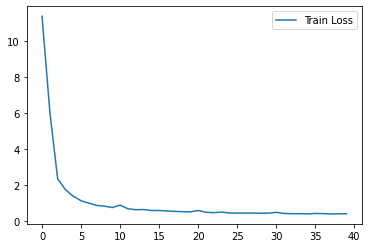

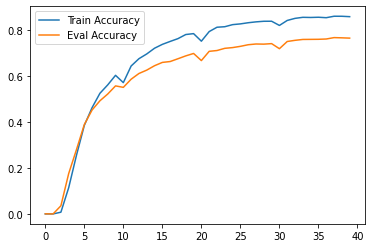

In [16]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
#plt.plot(list_train_acc, label='Train Accuracy')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()

plt.show()

plt.plot(list_train_acc, label='Train Accuracy')
plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()

In [ ]:
### 전체모델 저장
#save_model(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)